In [1]:
 %%capture
#!pip install wget
#!pip install torchsummaryX
#!pip install wandb

In [2]:
import pandas as pd
import cv2
import wget
import shutil
import os
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
import os
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import re
import json
import torch
import torch.utils.data as data
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchsummaryX import summary
from torch.optim import lr_scheduler
from IPython.core.display import display, HTML
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from datetime import datetime
import time
from os.path import exists
now = datetime.now()

/home/ngoc/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#wget https://github.com/Toloka/WSDMCup2023/raw/main/train.csv

In [4]:
DATA_DIR = "/home/ngoc/data/WSDM2023/"                          # If you run it on GG COLAB => /content/
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'         # Device
BATCH_SIZE = 2                                                 # Batch size
NUM_EPOCHS = 10                                                # Number of Epoch
EMBEDIND_SIZE = 32                                      # Embeding Size 
WORD_EMBEDING_SIZE = 32                                        # Embeding Size of Question
NUMBER_FC_LAYER = 2                                             # Number of Full-Connected layers# Number of Hidden node of FC layers
TEST_TRAINING  = True                                          # Running 1 batch                           
LEARNING_RATE = 0.000001                                         # Learning Rate
MAX_QUESTION_LENGTH = 41                                        # Max lenngh of Question 
MODEL = "VQA"                                                   # Model Name
IMAGE_SIZE = 640                                                # Size of image input
LOG_WANDB = False
LOSS = "RMSLE"
SAVE_IMAGE_FREQ = int(NUM_EPOCHS/5)                             #the frequency of saving predicted images to wandb
DATE = now.strftime("%d/%m/%Y %H:%M:%S")

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [6]:

if LOG_WANDB:
    import wandb
    wandb.init(project="WSDM2023",
               entity="ngocdunghuynh",
                config = {
                    "learning_rate": LEARNING_RATE,
                    "epochs": NUM_EPOCHS,
                    "batch_size": BATCH_SIZE,
                    "device": DEVICE,
                    "loss_function": LOSS,
                    "experiment": DATE,
                })

In [7]:
train = pd.read_csv(DATA_DIR  + 'train.csv')

In [8]:
TRAIN_IMGS_DIR = DATA_DIR + "train_imgs/"

In [9]:
# Download data
try:
    os.mkdir(TRAIN_IMGS_DIR)
    img_paths = Parallel(
    n_jobs=100)(delayed(wget.download)(img_url, out= TRAIN_IMGS_DIR) for img_url in tqdm(train.image)
    )
except:
    print("the training set has been downloaded")

the training set has been downloaded


In [10]:
#Get the image path from URL
train.image  = train.image.apply(lambda x: str(x.split("/")[-1]))
train.image  = train.image.apply(lambda x: TRAIN_IMGS_DIR + str(x))

In [11]:
#Spit the original training set into 2 dataframes
train_sample = int(len(train)*0.9)
df_train = train[:int(len(train)*0.9)]
df_val = train[int(len(train)*0.9):]

df_train = df_train.reset_index(drop =True)
df_val = df_val.reset_index(drop =True)

if TEST_TRAINING:
    df_train = df_train[:BATCH_SIZE*1000]
    df_val = df_val[:BATCH_SIZE*50]

In [12]:
def tokenize(sentence):

        """Split string lines into lists"""

        SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
        tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
        tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
        return tokens
        
class Text_Dict:

    """Aim to convert index to word or word to index"""

    def __init__(self, vocab):
        
        self.word_list = vocab
        self.word2idx_dict = {w:n_w for n_w, w in enumerate(self.word_list)}
        self.vocab_size = len(self.word_list)
        self.unk2idx = self.word2idx_dict['<unk>'] if '<unk>' in self.word2idx_dict else None

    def idx2word(self, n_w):

        return self.word_list[n_w]

    def word2idx(self, w):
        if w in self.word2idx_dict:
            return self.word2idx_dict[w]
        elif self.unk2idx is not None:
            return self.unk2idx
        else:
            raise ValueError(f'word {w} not in dictionary (while dictionary does not contain <unk>)')

    def tokenize_and_index(self, sentence):
        inds = [self.word2idx(w) for w in tokenize(sentence)]

        return inds

In [13]:
class Data_Loaders:

    """Aim to convert index to word or word to index"""

    def __init__(self, data_dir, df_train, df_val, batch_size, img_size, normalised_box):
        self.img_size = img_size
        self.df_train = df_train
        self.df_val = df_val
        self.batch_size = batch_size
        self.question_vocab, self.max_question_len = self.make_vocab_questions(pd.concat([df_train["question"],df_val["question"]], axis = 0))
        self.question_vocab_size = len(self.question_vocab)
        self.question_dict = Text_Dict(self.question_vocab)
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.data_dir = data_dir
        self.normalised_box  = normalised_box
        os.system(f'mkdir {self.data_dir + "resized_imgs"}')
        os.system(f'mkdir {self.data_dir + "resized_boxes"}')
        os.system(f'mkdir {self.data_dir + "processed_boxes"}')
        os.system(f'mkdir {self.data_dir + "processed_question"}')
        #self.transform = transforms.Compose([transforms.ToTensor(),
        #                                     transforms.Normalize((0.485, 0.456, 0.406),\
        #                                                          (0.229, 0.224, 0.225))])
     #Image and BBox Processing 
     #                                                             
    def create_mask(self, bb, x):
        """Creates a mask for the bounding box of same shape as image"""
        cols, rows,*_ = x.shape
        Y = np.zeros((cols, rows))
        bb = bb.astype(np.int64)
        Y[bb[1]:bb[3], bb[0]:bb[2]] = 1.
        return Y

    def mask_to_bb(self, Y):

        """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""

        rows , cols = np.nonzero(Y)
        if len(cols)==0: 
            return np.zeros(4, dtype=np.float64)
        top_row = np.min(rows)
        left_col = np.min(cols)
        bottom_row = np.max(rows)
        right_col = np.max(cols)
        return np.array([left_col, top_row, right_col, bottom_row], dtype=np.int64)

    def xyxy2xywh(self, box):

        """Normalise box from xyXY -> xywh"""

        xmin, ymin, xmax, ymax = box
        w = xmax - xmin         # Width of the box
        h = ymax - ymin         # Height of the box
        x_center = (xmin + (w/2))/self.img_size 
        y_center = (ymin + (h/2))/self.img_size 
        new_w = w/self.img_size 
        new_h = h/self.img_size
        return np.array([x_center,y_center, new_w, new_h], dtype=np.float64)

    def resize_image_bb(self, img_path, bb, sz):

        """Resize an image and its bounding box and write image to new path"""
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        mask = self.create_mask(bb, img)
        img_resized = cv2.resize(img, (sz, sz))
        mask_resized = cv2.resize(mask, (sz, sz))
        bb_resized = self.mask_to_bb(mask_resized)
        processed_box = self.xyxy2xywh(bb_resized)
        return img_resized, bb_resized, processed_box
    
    #Question Proxessing
    def make_vocab_questions(self, questions):

        """Make dictionary for questions and save them into text file."""

        vocab_set = set()
        SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
        question_length = []
        set_question_length = [None]*len(questions)
        for iquestion, question in enumerate(questions):
            words = SENTENCE_SPLIT_REGEX.split(question.lower())
            words = [w.strip() for w in words if len(w.strip()) > 0]
            vocab_set.update(words)
            set_question_length[iquestion] = len(words)
        question_length += set_question_length

        vocab_list = list(vocab_set)
        vocab_list.sort()
        vocab_list.insert(0, '<pad>')
        vocab_list.insert(1, '<unk>')
        return vocab_list, np.max(question_length)

    #data batch processing
    def vqa_processing(self,df):
        """Create a data list to store all raw data simples"""
        data = []
        for idx in range(len(df)):
            image_path, _, _, l, t, r,b, question = df.iloc[idx]
            data.append({
                "image_path" : image_path,
                "text_question": question,
                "bbox": np.array([l, t, r,b], dtype =np.float64) #Xmin Ymin Xmax Ymax
            })
        return data

    def data_processing(self, data, question_dict, transform):
        images = []
        text_questions = []
        token_questions = []
        bboxes = []
        image_paths = []
        for sample in data:
            file_name = sample["image_path"].split('/')[-1][:-4]
            if exists(self.data_dir + "resized_imgs/" + file_name + '.npy'):
                resized_image = np.load(self.data_dir + "resized_imgs/" + file_name + '.npy')
                bb_resized = np.load(self.data_dir + "resized_boxes/" + file_name + '.npy')
                processed_bb = np.load(self.data_dir + "processed_boxes/" + file_name + '.npy')
            else:
                resized_image,  bb_resized , processed_bb = self.resize_image_bb(sample["image_path"], sample["bbox"], self.img_size)
                np.save(self.data_dir + "resized_imgs/" + file_name + '.npy', resized_image)
                np.save(self.data_dir + "resized_boxes/" + file_name + '.npy', bb_resized)
                np.save(self.data_dir + "processed_boxes/" + file_name + '.npy', processed_bb)
                
            token_question = tokenize(sample["text_question"])
            question_2_idx = np.array([question_dict.word2idx(w) for w in token_question], dtype = int)
            question_2_idx = torch.tensor(question_2_idx)
            images.append(transform(resized_image))
            text_questions.append(sample["text_question"])
            token_questions.append(question_2_idx)
            if self.normalised_box:
                bboxes.append(processed_bb)
            else:
                bboxes.append(bb_resized)
            image_paths.append(sample["image_path"])
            
        images = np.array([np.array(image) for image in images], dtype = np.float64)
        bboxes = np.array(bboxes, dtype = np.float64)
        token_questions = nn.utils.rnn.pad_sequence(token_questions, padding_value = 0, batch_first =True)
        return {
            "image":torch.tensor(images),
            "question": token_questions,
            "text_question": text_questions,
            "bbox": torch.tensor(bboxes),
            "image_path": image_paths
        }

    def train_loader(self):
        train_data = self.vqa_processing(self.df_train)
        train_loader = torch.utils.data.DataLoader(
            dataset=train_data,
            batch_size=self.batch_size,
            collate_fn=lambda x: self.data_processing(x, self.question_dict, self.transform))
        return train_loader

    def val_loader(self):
        train_data = self.vqa_processing(self.df_val)
        train_loader = torch.utils.data.DataLoader(
            dataset=train_data,
            batch_size=self.batch_size,
            collate_fn=lambda x: self.data_processing(x, self.question_dict, self.transform))
        return train_loader

# Model

In [14]:
class ImageEncoder(nn.Module):

    def __init__(self, embedding_size, image_size):
        """
        Extract Image Features using 1 Dense Layer
        """
        super(ImageEncoder, self).__init__()
        self.VGG_NET = models.vgg16(weights="VGG16_Weights.DEFAULT")
        self.VGG_NET = self.VGG_NET.features
        self.VGG_NET.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(204800, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_size),
            nn.ReLU()
        )
        

    def forward(self, image):
        """Extract feature vector from image vector."""        
        image_feature = self.VGG_NET(image)
        return image_feature

In [15]:
class QuestionEncoder(nn.Module):

    def __init__(self, question_vocab_size, word_embedding_size, embedding_size):
        """
        Extract question featues:
            - step 1: using word2vec
            - step 2: using LSTM
        """
        super(QuestionEncoder, self).__init__()
        self.word2vec = nn.Embedding(question_vocab_size, word_embedding_size)
        self.lstm = nn.LSTM(word_embedding_size, embedding_size, batch_first=True)

    def forward(self, question):
        question_vec = self.word2vec(question)
        _, (hidden, cell) = self.lstm(question_vec)
        return hidden[0]

In [16]:
class VqaModel(nn.Module):

    def __init__(self,embedding_size, question_vocab_size, word_embedding_size, image_size):
        """
        Fusing Image feature and question feature using Full Connected Layer
        """
        super(VqaModel, self).__init__()
        self.image_encoder = ImageEncoder(embedding_size, image_size)
        self.question_encoder = QuestionEncoder(question_vocab_size, word_embedding_size, embedding_size)
        self.dense = nn.Linear(2*embedding_size, 4)
        self.sigmoid = nn.Sigmoid()
    def forward(self, image, question):

        image_feature = self.image_encoder(image)
        question_feature = self.question_encoder(question)
        
        combined_feature = torch.cat((image_feature, question_feature), 1)
        combined_feature = self.dense(combined_feature)

        return combined_feature.sigmoid()

# Training

In [17]:
def xywh_to_xyxy_batch(boxes1, boxes2, img_size):
    boxes1 = boxes1*img_size
    boxes2 = boxes2*img_size
    boxes1[:,0], boxes1[:,2] = boxes1[:, 0] - boxes1[:, 2] / 2, boxes1[:, 0] + boxes1[:, 2] / 2
    boxes1[:,1], boxes1[:,3] = boxes1[:, 1] - boxes1[:, 3] / 2, boxes1[:, 1] + boxes1[:, 3] / 2
    boxes2[:,0], boxes2[:,2] = boxes2[:, 0] - boxes2[:, 2] / 2, boxes2[:, 0] + boxes2[:, 2] / 2
    boxes2[:,1], boxes2[:,3] = boxes2[:, 1] - boxes2[:, 3] / 2, boxes2[:, 1] + boxes2[:, 3] / 2
    return boxes1, boxes2

In [18]:
def bbox_iou(boxes1, boxes2, img_size, xyxy = False):
    """
    Returns the IoU of two bounding boxes
    """
    if not xyxy:
        boxes1, boxes2 = xywh_to_xyxy_batch(boxes1, boxes2, img_size)
    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = boxes1[:, 0], boxes1[:, 1], boxes1[:, 2], boxes1[:, 3]
    b2_x1, b2_y1, b2_x2, b2_y2 = boxes2[:, 0], boxes2[:, 1], boxes2[:, 2], boxes2[:, 3]

    # get the coordinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1, 0) * torch.clamp(inter_rect_y2 - inter_rect_y1, 0)
    # Union Area
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    
    ious = inter_area / (b1_area + b2_area - inter_area + 1e-16)
    return ious
    

In [19]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='mean')
        
    def forward(self, pred, actual):
        loss = torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))
        return loss

In [20]:
def save_prediction(img_path, pred_bb, gt_bb, question, epoch):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    result = img.copy()
    cv2.rectangle(result, (int(gt_bb[0]), int(gt_bb[1])), (int(gt_bb[2]), int(gt_bb[3])), (0, 255, 0), 3)
    cv2.rectangle(result, (int(pred_bb[0]), int(pred_bb[1])), (int(pred_bb[2]), int(pred_bb[3])), (255, 0, 0), 3)
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(question)
    plt.savefig(f"./saved_images/epoch_{epoch}_" + img_path.split("/")[-1])
    plt.close()

In [21]:
def train_loop(epoch, data_loaders, model, loss_fn, optimizer, train_table):
    start_time = time.time()
    running_loss = 0.0
    running_iou = 0.0
    train_loader = data_loaders.train_loader()
    batch_size = data_loaders.batch_size
    size = len( data_loaders.df_train)
    num_batch =  size/batch_size
    for batch_idx, batch_data in enumerate(train_loader):
        images, questions = batch_data["image"].float().to(DEVICE), batch_data["question"].to(DEVICE)
        targets = batch_data["bbox"].float().to(DEVICE)
        
        # Compute prediction and loss
        preds = model(images, questions)
        loss = loss_fn(preds, targets)
        running_loss +=  loss.item()

        #Cal ious
        if data_loaders.normalised_box:
            ious = bbox_iou(preds, targets, data_loaders.img_size)
        else:
            ious = bbox_iou(preds, targets, data_loaders.img_size, xyxy=True)
        mean_iou = torch.mean(ious).item()

        running_iou += mean_iou
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #WandB log
        if LOG_WANDB:
            wandb.log({
                "loss_step": loss.item(),
                "iou_step": mean_iou
            })
        if (batch_idx +1) % 200 == 0:
            print(f'    [{(batch_idx+1)*batch_size}/{size}] | Loss : {loss.item():>7f} | IoU: {mean_iou:>5f}')
    running_loss = running_loss/num_batch
    running_iou = running_iou/num_batch

    #WandB log
    if LOG_WANDB:
        wandb.log({
            "epoch": epoch+1,
            "loss": running_loss,
            "iou": running_iou
        })
        if (epoch + 1) % SAVE_IMAGE_FREQ == 0:
            if data_loaders.normalised_box:
                preds, targets = xywh_to_xyxy_batch(preds, targets, data_loaders.img_size)
            for idx in range(len(targets)):
                img_path = batch_data['image_path'][idx]
                ques_text = batch_data['text_question'][idx]
                target = targets[idx]
                prediction = preds[idx]
                save_prediction(img_path, prediction, target, ques_text, epoch+1)
                train_table.add_data(epoch+1, "train", wandb.Image(f"./saved_images/epoch_{epoch+1}_" + img_path.split("/")[-1]), ious[idx].item())
            
    print(f'\nTRAINING | Loss: {running_loss:>7f} | IoU: {running_iou:>5f} | Running_time : {time.time() - start_time:>5f}s')
    return running_loss, running_iou, train_table

In [22]:
def val_loop(epoch, data_loaders, model, loss_fn, val_table):
    start_time = time.time()
    running_loss = 0.0
    running_iou = 0.0
    val_loader = data_loaders.val_loader()
    batch_size = data_loaders.batch_size
    num_batch =  len( data_loaders.df_val)/batch_size
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(val_loader):
            images, questions = batch_data["image"].float().to(DEVICE), batch_data["question"].to(DEVICE)
            targets = batch_data["bbox"].float().to(DEVICE)
            # Compute prediction and loss
            preds = model(images, questions)
            loss = loss_fn(preds, targets)
            running_loss +=  loss.item()

            #Cal ious
            if data_loaders.normalised_box:
                ious = bbox_iou(preds, targets, data_loaders.img_size)
            else:
                ious = bbox_iou(preds, targets, data_loaders.img_size, xyxy=True)
                
            running_iou += torch.mean(ious).item()
            
    running_loss = running_loss/num_batch
    running_iou = running_iou/num_batch
    print(f'VAL      | Loss: {running_loss:>7f} | IoU: {running_iou:>5f} | Running_time : {time.time() - start_time:>5f}s')

    if LOG_WANDB:
        wandb.log({
            "epoch": epoch+1,
            "val_loss":  running_loss,
            "val_iou": running_iou
        })
        if (epoch + 1) % SAVE_IMAGE_FREQ == 0:
            if data_loaders.normalised_box:
                preds, targets = xywh_to_xyxy_batch(preds, targets, data_loaders.img_size)
            for idx in range(len(targets)):
                img_path = batch_data['image_path'][idx]
                ques_text = batch_data['text_question'][idx]
                target = targets[idx]
                prediction = preds[idx]
                save_prediction(img_path, prediction, target, ques_text, epoch+1)
                val_table.add_data(epoch+1, "val", wandb.Image(f"./saved_images/epoch_{epoch+1}_" + img_path.split("/")[-1]), ious[idx].item())
    return running_loss, running_iou, val_table

In [23]:
data_loaders = Data_Loaders(DATA_DIR, df_train, df_val, BATCH_SIZE, IMAGE_SIZE, normalised_box=True)

val_loader = data_loaders.val_loader()

model = VqaModel(
    embedding_size=EMBEDIND_SIZE,
    question_vocab_size=data_loaders.question_vocab_size,
    word_embedding_size=WORD_EMBEDING_SIZE,
    image_size = IMAGE_SIZE
).to(DEVICE)

params = list(model.image_encoder.VGG_NET.classifier.parameters()) \
        + list(model.question_encoder.parameters()) \
        + list(model.dense.parameters()) \
        + list(model.sigmoid.parameters())

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = RMSLELoss()  #or nn.MSELoss(reduction='mean')

if LOG_WANDB:
    os.system('mkdir saved_images')
    columns=["epoch", "dataset", "image", "iou"]
    train_table = wandb.Table(columns=columns)
    val_table = wandb.Table(columns=columns)
else:
    train_table = None
    val_table = None
logs = {
        "loss": [],
        "iou": [],
        "val_loss": [],
        "val_iou": []
        }

for epoch in range(NUM_EPOCHS):
    print("------------------------------------------------------------------------------------------------")
    print('------------------------------------------------------------------------------------------------')
    print(f"EPOCH {epoch+1}\n")

    loss, iou, train_table = train_loop(epoch, data_loaders, model, loss_fn, optimizer, train_table)
    val_loss, val_iou, val_table= val_loop(epoch, data_loaders, model, loss_fn, val_table)
    
    logs["loss"].append(loss)
    logs["iou"].append(iou)
    logs["val_loss"].append(val_loss)
    logs["val_iou"].append(val_iou)

mkdir: cannot create directory ‘/home/ngoc/data/WSDM2023/resized_imgs’: File exists
mkdir: cannot create directory ‘/home/ngoc/data/WSDM2023/resized_boxes’: File exists
mkdir: cannot create directory ‘/home/ngoc/data/WSDM2023/processed_boxes’: File exists
mkdir: cannot create directory ‘/home/ngoc/data/WSDM2023/processed_question’: File exists


------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
EPOCH 1

    [400/2000] | Loss : 0.153703 | IoU: 0.017039
    [800/2000] | Loss : 0.121272 | IoU: 0.065749
    [1200/2000] | Loss : 0.117412 | IoU: 0.000000
    [1600/2000] | Loss : 0.092372 | IoU: 0.129329
    [2000/2000] | Loss : 0.132310 | IoU: 0.000000

TRAINING | Loss: 0.147344 | IoU: 0.057592 | Running_time : 140.282567s
VAL      | Loss: 0.133767 | IoU: 0.046644 | Running_time : 2.395473s
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
EPOCH 2

    [400/2000] | Loss : 0.080534 | IoU: 0.091115
    [800/2000] | Loss : 0.094519 | IoU: 0.076032
    [1200/2000] | Loss : 0.088060 | IoU: 0.000000
    [1600/2000] | Loss : 0.080375 | IoU: 0.140350
    [20

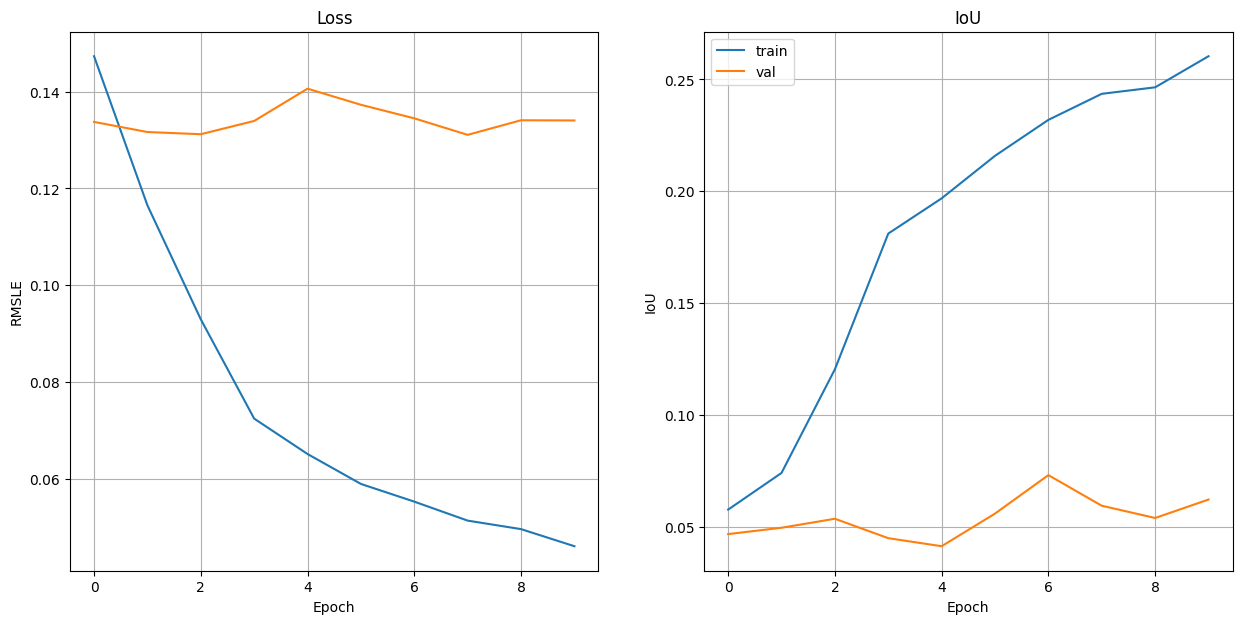

In [24]:

plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.plot(logs["loss"], label='train')
plt.plot(logs["val_loss"], label='val')
plt.title("Loss")
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('RMSLE')

plt.subplot(1, 2, 2) # index 2
plt.plot(logs["iou"], label='train')
plt.plot(logs["val_iou"], label='val')
plt.title("IoU")
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.ylabel('IoU')
plt.show()

In [25]:
if LOG_WANDB:
    wandb.log({"train example": train_table})
    wandb.log({"val example": val_table})
    os.system('rm -rf saved_images')
    wandb.finish()